In [396]:
import numpy as np

from scipy.optimize import minimize , LinearConstraint , BFGS
from scipy.sparse import csr_matrix , issparse

import matplotlib.pyplot as plt
%matplotlib notebook

def spy( A , b=None ) : 
    plt.figure( figsize=(10,3) )
    plt.xticks([]) ; plt.yticks([])
    if issparse(A) : A = A.toarray()
    if b is None : 
        plt.imshow( A != 0 , cmap='Greys' , interpolation='nearest', aspect='auto' )
    else : 
        X = np.zeros( ( A.shape[0] , A.shape[1]+4 ) )
        X[:,:A.shape[1]] = A
        X[:,A.shape[1]+3] = b
        plt.imshow( X != 0 , cmap='Greys' , interpolation='nearest', aspect='auto' )
        

In [397]:

def fitLogit( x , PT ) : 
    
    N = x.size
    
    bc , cc = np.sum( PT * x ) / N , np.sum( PT ) / N
    
    def obj( p ) : 
        return np.sum( np.log1p( np.exp( p[0] * x + p[1] ) ) ) / N - bc * p[0] - cc * p[1]
    
    def jac( p ) : 
        g  = np.zeros(2)
        eU = np.exp( p[0] * x + p[1] )
        PL = eU / ( 1.0 + eU )
        g[0] = np.sum( PL * x ) / N - bc
        g[1] = np.sum( PL ) / N - cc
        return g
    
    def hess( p ) : 
        H = np.zeros((2,2))
        eU = np.exp( p[0] * x + p[1] )
        PL = eU / ( 1.0 + eU )
        PL = PL * ( 1.0 - PL )
        H[0,0] = np.sum( PL * x * x ) / N
        H[0,1] = np.sum( PL * x ) / N
        H[1,0] = H[0,1]
        H[1,1] = np.sum( PL ) / N
        return H
    
    p0 = np.random.randn( 2 )
    return minimize( obj , p0 , jac=jac , hess=hess , method='trust-constr' , \
                     options={ 'maxiter' : 100000 , 'gtol' : 1.0e-6 } )


In [469]:

def fitIdLogit( x , y , I , i , Lambda1=None , Lambda2=None ) : 
    
    N = x.size
    
    K = 2
    
    Nvars = K + 2*K*I # b in R(K) , d , s in R(I,K)
    Ncons = K + 2*K*I # d(1,:) + ... + d(I,:) = 0 (K constraints, KI nonzeros), 
                      # s - d >= 0  ,  s + d >= 0 (KI constraints, 4KI nonzeros)
            
    KIp1 = K*(I+1)
    
    Nrange , Irange = np.arange(N) , np.arange(I)
    
    ny = - y ; nyx = ny * x
    
    # map of coefficients to "- y (x,1)' (b+d)" terms
    Znnzs = 2*K*N
    Zdata = np.zeros( Znnzs )
    Zrows , Zcols = np.zeros( Znnzs , dtype=np.int ) , np.zeros( Znnzs , dtype=np.int )
    
    """
    b , bb = 0 , N
    for k in range(K) : 
        
        Kkp1 = K*(k+1)
        
        # beta terms
        Zdata[b:bb] = nyx
        Zrows[b:bb] = Nrange
        Zcols[b:bb] = k
        b = bb ; bb += N
        
        # delta terms
        Zdata[b:bb] = nyx
        Zrows[b:bb] = Nrange
        Zcols[b:bb] = k
        b = bb ; bb += N
    """
        
    # beta terms
    Zdata[:N] , Zdata[N:2*N] = nyx , ny
    Zrows[:N] , Zrows[N:2*N] = Nrange , Nrange
    Zcols[:N] , Zcols[N:2*N] = 0 , 1
    
    # delta terms
    Zdata[2*N:3*N] , Zdata[3*N:] = nyx , ny
    Zrows[2*N:3*N] , Zrows[3*N:] = Nrange , Nrange
    Zcols[2*N:3*N] , Zcols[3*N:] = K + i , 2*K + i

    Z = csr_matrix( (Zdata,(Zrows,Zcols)) , shape=( N , KIp1 ) )
    
    # constraints

    lo , up = np.zeros( Ncons ) , np.inf * np.ones( Ncons )
    for k in range(K) : up[k] = 0.0

    Cnnzs = 5*K*I
    Cdata = np.ones( Cnnzs ) # almost all entries are ones, so initialize that way
    Crows , Ccols = np.zeros( Cnnzs , dtype=np.int ) , np.zeros( Cnnzs , dtype=np.int )
    
    b , bb = 0 , I
    for k in range(K) : 
        
        # deltas sum to zero constraints
        Crows[b:bb] = k
        Ccols[b:bb] = K + k*I + Irange
        b = bb ; bb += I
        
        # slack terms, s(:,k) - d(:,k) >= 0 , s(:,k) + d(:,k) >= 0
        
        # deltas
        Crows[b:bb] = K + k*I + Irange # skip K for betas, and k*I for previously assigned rows
        Ccols[b:bb] = K + k*I + Irange 
        Cdata[b:bb] = -1.0
        b = bb ; bb += I
        
        # slacks
        Crows[b:bb] = K + k*I + Irange # skip K for betas, and k*I for previously assigned rows
        Ccols[b:bb] = KIp1 + k*I + Irange 
        b = bb ; bb += I
        
        # deltas
        Crows[b:bb] = KIp1 + k*I + Irange # skip K+KI for betas and above, and k*I for previously assigned rows
        Ccols[b:bb] = K + k*I + Irange 
        b = bb ; bb += I
        
        # slacks
        Crows[b:bb] = KIp1 + k*I + Irange # skip K+KI for betas and above, and k*I for previously assigned rows
        Ccols[b:bb] = KIp1 + k*I + Irange
        b = bb ; bb += I 
        
    Cmtrx = csr_matrix( (Cdata,(Crows,Ccols)) , shape=( Ncons , Nvars ) )
    
    # spy( Cmtrx )

    cons = LinearConstraint( Cmtrx , lo , up )
    
    L1 = 1.0 if Lambda1 is None else np.float64(Lambda1) / N
    L2 = 1.0 if Lambda2 is None else np.float64(Lambda2) / N
    
    print( "fitting idLogit: " , L1 , L2 )
    
    def obj( p ) :
        eU = np.exp( Z @ p[:KIp1] )
        ll = np.log1p( eU )
        return np.sum( ll ) / N \
                    + L1 * np.sum( p[KIp1:] ) \
                    + L2 * np.sum( p[K:KIp1] * p[K:KIp1] ) / 2.0
        
    def jac( p ) :  
        g = np.zeros( Nvars )
        eU = np.exp( Z @ p[:KIp1] )
        PL = eU / ( 1.0 + eU )
        g[:KIp1] = Z.T @ PL / N
        if( L2 > 0.0 ) : g[K:KIp1] += L2 * p[K:KIp1]
        g[KIp1:] = L1
        return g
    
    def hessp( p , v ) :  
        h = np.zeros( Nvars )
        zv = Z @ v[:KIp1]
        eU = np.exp( Z @ p[:KIp1] )
        PL = eU / ( 1.0 + eU )
        PL = PL * ( 1.0 - PL )
        h[:KIp1] = Z.T @ ( zv * PL ) / N
        if( L2 > 0.0 ) : h[K:KIp1] += L2 * v[K:KIp1]
        return h
    
    def grad_check( p=None , verbose=True ) : 

        """
        gradient check of an object that has certain attributes (Nvars, obj, and grad)

        """

        if p is None : 
            p = np.random.rand( Nvars )
            p[0:C] = p[0:C] / p[0:C].sum()

        f0 , g0 = obj( p ) , jac( p ) # original objective and gradient

        Hs = 10.0**np.arange( -10 , 0 , 1 )[::-1] # perturbation sizes
        pP = p.copy() # copy for perturbed betas

        df = np.zeros( Nvars ) # space for dinite differences
        ds = np.zeros( Hs.size ) # differences between gradient and finite differences
        
        # iterations
        for h in range( Hs.size ) : 
            H = Hs[h] # actual perturbation
            for k in range( Nvars ) : 
                pP[k] += H # perturb on coordinate k
                fk = obj( pP ) # evalute objective at perturbed argument
                df[k] = ( fk - f0 ) / H # compute finite difference
                pP[k] -= H # perturb on coordinate k
            ds[h] = np.max( np.abs( g0 - df ) ) # compute difference

        if( verbose ) : 
            for h in range( Hs.size ) : 
                print( "%0.16f , %0.16f" % ( Hs[h] , ds[h] ) )

        return Hs , ds
    
    # grad_check()
    
    p0 = np.random.randn( Nvars )
    return minimize( obj , p0 , jac=jac , hessp=hessp , method='trust-constr' , constraints=cons , \
                     options={ 'maxiter' : 100000 , 'gtol' : 1.0e-6 } )


In [439]:
x = np.random.randn( 2 )
y = 2.0 * ( np.random.rand() <= 0.5 ) - 1.0 
I = 2
i = np.array([0,1])

fitIdLogit( x , y , I , i )

0.1000000000000000 , 0.1099895733918919
0.0100000000000000 , 0.0110075321752676
0.0010000000000000 , 0.0011008335900629
0.0001000000000000 , 0.0001100841635635
0.0000100000000000 , 0.0000110085269796
0.0000010000000000 , 0.0000011011631615
0.0000001000000000 , 0.0000001203857343
0.0000000100000000 , 0.0000001133380568
0.0000000010000000 , 0.0000010812237445
0.0000000001000000 , 0.0000125483304489


 barrier_parameter: 2.560000000000001e-07
 barrier_tolerance: 2.560000000000001e-07
          cg_niter: 30
      cg_stop_cond: 4
            constr: [array([-2.64697796e-23, -2.64697796e-23,  5.41293311e-07,  1.95028499e-07,
        2.63857539e-07,  4.94952008e-07,  5.76417882e-07,  1.59903928e-07,
        3.90731602e-07,  3.68077944e-07])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 2.6469779601696886e-23
    execution_time: 0.12007570266723633
               fun: 3.232403768131529e-06
              grad: array([ 3.08937437e-07, -2.42141017e-07,  2.06072836e-07,  1.02864602e-07,
       -8.90055837e-09, -2.33240459e-07,  2.00000000e+00,  2.00000000e+00,
        2.00000000e+00,  2.00000000e+00])
               jac: [<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 20 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([ 3.08937437e-07, -2.42141017e-07,  3.19820781e-15, -2.91441665

## LC Logit

We can write the objective as
$$
\begin{aligned}
    - \frac{1}{N} \sum_x \left[ 
            P_x \log \left( \sum_{c=1}^C \rho_c e^{L_{x,c}^-} \right)
            + (1-P_x) \log \left( \sum_{c=1}^C \rho_c e^{L_{x,c}^+} \right)
        \right]
\end{aligned}
$$
where
$$
    L_{x,c}^- = \log P_{x,c}^L = - \log( 1 + e^{-\beta_c x - \gamma_c} )
    \quad\quad\text{and}\quad\quad
    L_{x,c}^+ = \log ( 1- P_{x,c}^L ) = - \log ( 1 + e^{\beta_c x + \gamma_c} )
$$
The intra-class coefficient derivatives of these terms are
$$
\begin{aligned}
    D_c^\beta L_{x,c}^-
        &= \frac{e^{-\beta_c x - \gamma_c}}{1 + e^{-\beta_c x - \gamma_c}} x 
        = P_{x,c}^{L,-} x
    \quad\quad\quad\quad
    && D_c^\gamma L_{x,c}^-
        = \frac{e^{-\beta_c x - \gamma_c}}{1 + e^{-\beta_c x - \gamma_c}} 
        = P_{x,c}^{L,-}
        \\ 
    D_c^\beta L_{x,c}^+
        &= - \frac{e^{\beta_c x + \gamma_c}}{1 + e^{\beta_c x + \gamma_c}} x
        = - P_{x,c}^{L,+} x
    \quad\quad\quad\quad
    && D_c^\gamma L_{x,c}^+
        = - \frac{e^{\beta_c x + \gamma_c}}{1 + e^{\beta_c x + \gamma_c}}
        = - P_{x,c}^{L,+}
\end{aligned}
$$

While this transformation seems trivial, consider the objective in the form
$$
\begin{aligned}
    \\
    - \frac{1}{N} 
        \sum_x \left[ 
            P_x \log \left( \sum_{c=1}^C \rho_c e^{L_{x,c}^- - L_{x,*}^-} \right)
            + (1-P_x) \log \left( \sum_{c=1}^C \rho_c e^{L_{x,c}^+ - L_{x,*}^+} \right)
        \right]
            - \frac{1}{N} \sum_x P_x L_{x,*}^-
            - \frac{1}{N} \sum_x (1-P_x) L_{x,*}^+ \\
    \\
\end{aligned}
$$
where 
$$
    L_{x,*}^- = \max_c L_{x,c}^-
    \quad\quad\text{and}\quad\quad
    L_{x,*}^+ = \max_c L_{x,c}^+
$$
We are much less likely to try to compute $\log 0$ in this form, because all the exponents are non-positive and at least one is exactly zero. 


Consider then the $\rho_c$ derivatives:
$$
\begin{aligned}
    D_c^\rho 
        &= - \frac{1}{N} \sum_x \left[ 
                P_x \left( \frac{ e^{L_{x,c}^-} }{ \sum_{d=1}^C \rho_d e^{L_{x,d}^-} } \right)
                + (1-P_x) \left( \frac{ e^{L_{x,d}^+} }{ \sum_{d=1}^C \rho_d e^{L_{x,d}^+} } \right)
            \right] \\ 
        &= - \frac{1}{N} \sum_x \left[ 
                P_x Q_{x,c}^-
                + (1-P_x) Q_{x,c}^+
            \right] \\ 
\end{aligned}
$$
Or the $\beta_c$ derivatives: 
$$
\begin{aligned}
    D_c^\beta 
        &= - \frac{1}{N} \sum_x \left[ 
                P_x \left( \frac{ \rho_c e^{L_{x,c}^-} }{ \sum_{d=1}^C \rho_d e^{L_{x,d}^-} } \right) (D_c^\beta L_{x,c}^-)
                + (1-P_x) \left( \frac{ \rho_c e^{L_{x,d}^+} }{ \sum_{d=1}^C \rho_d e^{L_{x,d}^+} } \right)(D_c^\beta L_{x,c}^+)
            \right] \\ 
        &= - \frac{\rho_c}{N} \sum_x \left[ 
                P_x Q_{x,c}^- P_{x,c}^{L,-} x
                - (1-P_x) Q_{x,c}^+ P_{x,c}^{L,+} x
            \right] \\ 
\end{aligned}
$$
Or the $\gamma_c$ derivatives: 
$$
\begin{aligned}
    D_c^\gamma 
        &= - \frac{1}{N} \sum_x \left[ 
                P_x \left( \frac{ \rho_c e^{L_{x,c}^-} }{ \sum_{d=1}^C \rho_d e^{L_{x,d}^-} } \right) (D_c^\gamma L_{x,c}^-)
                + (1-P_x) \left( \frac{ \rho_c e^{L_{x,d}^+} }{ \sum_{d=1}^C \rho_d e^{L_{x,d}^+} } \right)(D_c^\gamma L_{x,c}^+)
            \right] \\ 
        &= - \frac{\rho_c}{N} \sum_x \left[ 
                P_x Q_{x,c}^- P_{x,c}^{L,-}
                - (1-P_x) Q_{x,c}^+ P_{x,c}^{L,+}
            \right] \\ 
\end{aligned}
$$

In [190]:
def fitLCLogit( x , PT ) : 
    
    N = x.size
    C = 2
    Nvars = 3*C
    
    o = np.ones(N)
    
    omPT = 1.0 - PT # this gets reused, so don't recompute it
    
    PTx , omPTx = PT * x , omPT * x
    
    def obj( p ) : 
        
        w = p[0:C] ; b = p[C:2*C] ; c = p[2*C:3*C]
        U = np.outer( x , b ) + np.outer( o , c )
        
        Lm  , Lp  = - np.log1p( np.exp( -U ) ) , - np.log1p( np.exp( U ) )
        LmM , LpM = np.max( Lm , axis=1 ) , np.max( Lp , axis=1 )
        Lm  , Lp  = Lm - np.outer( LmM , np.ones(C) ) , Lp - np.outer( LpM , np.ones(C) )
        Em  , Ep  = np.exp( Lm ) , np.exp( Lp )

        f  = 0.0
        f -= np.dot( PT , np.log( Em @ w ) ) / N
        f -= np.dot( PT , LmM ) / N
        f -= np.dot( omPT , np.log( Ep @ w ) ) / N
        f -= np.dot( omPT , LpM ) / N
        
        return f
    
    def jac( p ) : 
        
        g  = np.zeros( Nvars )
        
        w = p[0:C] ; b = p[C:2*C] ; c = p[2*C:3*C]
        U = np.outer( x , b ) + np.outer( o , c )
        
        eUm , eUp = np.exp( -U ) , np.exp( U )
        
        Lm  , Lp  = - np.log1p( np.exp( -U ) ) , - np.log1p( np.exp( U ) )
        LmM , LpM = np.max( Lm , axis=1 ) , np.max( Lp , axis=1 )
        Lm  , Lp  = Lm - np.outer( LmM , np.ones(C) ) , Lp - np.outer( LpM , np.ones(C) )
        Em  , Ep  = np.exp( Lm ) , np.exp( Lp )
        
        Dm , Dp = Em @ w , Ep @ w
        for i in range(C) : 
            Em[:,i] , Ep[:,i] = Em[:,i] / Dm , Ep[:,i] / Dp
            
        # "rho" derivatives
        g[0:C] = - ( Em.T @ PT + Ep.T @ omPT ) / N
        
        PLm , PLp = eUm / ( 1.0 + eUm ) , eUp / ( 1.0 + eUp )
        Em  , Ep  = Em * PLm , Ep * PLp
        
        # "beta" derivatives
        g[  C:  2*C] = - w * ( Em.T @ PTx - Ep.T @ omPTx ) / N
        
        # "gamma" derivatives
        g[2*C:Nvars] = - w * ( Em.T @ PT  - Ep.T @ omPT  ) / N
        
        return g
    
    def grad_check( p=None , verbose=True ) : 

        """
        gradient check of an object that has certain attributes (Nvars, obj, and grad)

        """

        if p is None : 
            p = np.random.rand( Nvars )
            p[0:C] = p[0:C] / p[0:C].sum()

        f0 , g0 = obj( p ) , jac( p ) # original objective and gradient

        Hs = 10.0**np.arange( -10 , 0 , 1 )[::-1] # perturbation sizes
        pP = p.copy() # copy for perturbed betas

        df = np.zeros( Nvars ) # space for dinite differences
        ds = np.zeros( Hs.size ) # differences between gradient and finite differences
        
        # iterations
        for h in range( Hs.size ) : 
            H = Hs[h] # actual perturbation
            for k in range( Nvars ) : 
                pP[k] += H # perturb on coordinate k
                fk = obj( pP ) # evalute objective at perturbed argument
                df[k] = ( fk - f0 ) / H # compute finite difference
                pP[k] -= H # perturb on coordinate k
            ds[h] = np.max( np.abs( g0 - df ) ) # compute difference

        if( verbose ) : 
            for h in range( Hs.size ) : 
                print( "%0.16f , %0.16f" % ( Hs[h] , ds[h] ) )

        return Hs , ds
    
    # constraints: 
    #  
    #     p[0] , p[1] , ... , p[C] >= 0.0 (C constraints)
    #     p[0] + p[1] + ... + p[C] = 1.0 (1 constraint)
    # 

    lo , up = np.zeros( C+1 ) , np.inf * np.ones( C+1 ) ; lo[C] , up[C] = 1.0 , 1.0
    Cmtrx = np.zeros( ( C+1 , 3*C ) )
    for c in range(C) : 
        Cmtrx[c,c] = 1.0 # p[c] >= 0
        Cmtrx[C,c] = 1.0 # sum_c p[c] = 1
        
    cons = LinearConstraint( Cmtrx , lo , up )
    
    # grad_check()
    
    p0 = np.random.randn( Nvars ) ; p0[0:C] = np.abs(p0[0:C]) ; p0[0:C] = p0[0:C] / p0[0:C].sum()
    return minimize( obj , p0 , jac=jac , hess=BFGS() , constraints=cons , method='trust-constr' , \
                     options={ 'maxiter' : 1000 , 'gtol' : 1.0e-6 } )


If we were _really_ concerned, we could also pull in $\rho_c$ with 
$$
\begin{aligned}
    - \frac{1}{N} \sum_x \left[ 
            P_x \log \left( \sum_{c=1}^C e^{L_{x,c}} \right)
            + (1-P_x) \log \left( \sum_{c=1}^C e^{M_{x,c}} \right)
        \right]
\end{aligned}
$$
where
$$
    L_{x,c} = \log \rho_c + \log P_{x,c}^L
    \quad\quad\text{and}\quad\quad
    M_{x,c} = \log \rho_c + \log ( 1- P_{x,c}^L )
$$
Then 
$$
\begin{aligned}
    - \frac{1}{N} 
        \sum_x \left[ 
            P_x \log \left( \sum_{c=1}^C e^{L_{x,c}-L_x^*} \right)
            + (1-P_x) \log \left( \sum_{c=1}^C e^{M_{x,c}-M_x^*} \right)
        \right]
            - \frac{1}{N} \sum_x P_x L_x^*
            - \frac{1}{N} \sum_x (1-P_x) M_x^*
\end{aligned}
$$
where we use the redefined values of $L_{x,c}$ and $M_{x,c}$ in defining $L_x^*$ and $M_x^*$. This formula can never try to compute $\log 0$, because the $\log$s are always of quantities that are at least one. 

Of course, 
$$
    L_{x,c} = \log \rho_c + \beta_c x + \gamma_c - \log( 1 + e^{ \beta_c x + \gamma_c } )
    \quad\quad\text{and}\quad\quad
    M_{x,c} = \log \rho_c - \log( 1 + e^{ \beta_c x + \gamma_c } )
$$
Thus the gradients of these terms are
$$
    \nabla_c L_{x,c} 
        = \begin{pmatrix} 1/\rho_c \\ x - P_{x,c}^L x \\ 1 - P_{x,c}^L \end{pmatrix}
        = \begin{pmatrix} 1/\rho_c \\ x e^{M_{x,c}} \\ e^{M_{x,c}} \end{pmatrix}
    \quad\quad\text{and}\quad\quad
    \nabla_c M_{x,c} 
        = \begin{pmatrix} 1/\rho_c \\ - P_{x,c}^L x \\ - P_{x,c}^L \end{pmatrix}
        = \begin{pmatrix} 1/\rho_c \\ - x e^{L_{x,c}} \\ - e^{L_{x,c}} \end{pmatrix}
$$

Consider then the class-coefficient derivatives
$$
\begin{aligned}
    \nabla_c 
        &= - \frac{1}{N} \sum_x \left[ 
                P_x \left( \frac{ e^{L_{x,c}} }{ \sum_{d=1}^C e^{L_{x,d}} } \right)
                        \nabla_c L_{x,c}
                + (1-P_x) \left( \frac{ e^{M_{x,d}} }{ \sum_{d=1}^C e^{M_{x,d}} } \right)
                        \nabla_c M_{x,c}
            \right] \\ 
        &= - \frac{1}{N} \sum_x \left[ 
                P_x \left( \frac{ e^{L_{x,c} - L_x^* } }{ \sum_{d=1}^C e^{L_{x,d} - L_x^*} } \right)
                           \nabla_c L_{x,c}
                + (1-P_x) \left( \frac{ e^{M_{x,d} - M_x^*} }{ \sum_{d=1}^C e^{M_{x,d} - M_x^*} } \right)
                        \nabla_c M_{x,c}
            \right] \\ 
\end{aligned}
$$
These are better controlled as well. In the odd case $\rho_c = 0$, note that $\log \rho_c = -\infty$ and hence $e^{L_{x,c} - L_x^*} = 0$; thus we can just take $D_c^\rho = 0$ in that case (we could prove this more rigorously, if we like, but it holds). 


## RC Logit

To fit an RC Logit model, we solve
$$
    \min_{\boldsymbol{\mu},\mathbf{L}} - \frac{1}{N} \sum_x \left[ P_x \log \int P_x^L(\boldsymbol{\mu}+\mathbf{Lv})\phi(\mathbf{v})d\mathbf{v}
            + (1-P_x) \log \left( 1 - \int P_x^L(\boldsymbol{\mu}+\mathbf{Lv})\phi(\mathbf{v})d\mathbf{v} \right) \right] 
$$
or, using approximations to the integral, 
$$
    \min_{\boldsymbol{\mu},\mathbf{L}} - \frac{1}{N} \sum_x \left[ P_x \log \left( \sum_{s=1}^S w_s P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s) \right)
            + (1-P_x) \log \left( 1 - \sum_{s=1}^S w_s  P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s) \right) \right] 
$$
given sample points $\{\mathbf{v}_s,w_s\}_{s=1}^S$

The objective
$$
    -\frac{1}{N} \sum_x \left[ P_x \log \left( \sum_{s=1}^S w_s P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s) \right)
            + (1-P_x) \log \left( 1 - \sum_{s=1}^S w_s  P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s) \right) \right] 
$$
can be computed by 
$$
\begin{aligned}
    &\quad \mathrm{Given}\;\; \mathbf{x} \in \mathbb{R}^N \;,\; \mathbf{P} \in \mathbb{R}^N \;,\; \mathbf{V} \in \mathbb{R}^{2 \times S} \; , \; \mathbf{w} \in \mathbb{R}^S \\
    &\quad \boldsymbol{\Theta} \leftarrow \boldsymbol{\mu}\mathbf{1}^\top + \mathbf{LV} \in \mathbb{R}^{2 \times S} \\
    &\quad \mathbf{U} \leftarrow [ \; \mathbf{x} \; \mathbf{1} \; ] \; \boldsymbol{\Theta} \in \mathbb{R}^{N \times S} \\
    &\quad \mathbf{E} \leftarrow \mathrm{exp} \{ \mathbf{U} \} \in \mathbb{R}^{N \times S} \\
    &\quad \mathbf{P}^L \leftarrow \mathbf{E} \; / \; ( 1 + \mathbf{E} ) \in \mathbb{R}^{N \times S} \\
    &\quad \mathbf{q} \leftarrow \mathbf{P}^L \; \mathbf{w} \in \mathbb{R}^{N} \\
    &\quad \mathbf{l} \leftarrow \log(\mathbf{Q}) \\ 
    &\quad \mathbf{m} \leftarrow \log(1-\mathbf{Q}) \\
    &\quad \ell \leftarrow - \; ( \; \mathbf{l}^\top\mathbf{P} + \mathbf{m}^\top(1-\mathbf{P}) \; ) \; / \; N
\end{aligned}
$$


If we want to stabilize, we have to do the following: 
$$
\begin{aligned}
    &-\frac{1}{N} \sum_x \left[ P_x \log \left( \sum_{s=1}^S w_s e^{L_{x,s}^-} \right)
            + (1-P_x) \log \left( \sum_{s=1}^S w_s e^{L_{x,s}^+} \right) \right] \\
    &\quad\quad\quad\quad
        = -\frac{1}{N} \sum_x \left[ P_x \log \left( \sum_{s=1}^S w_s e^{L_{x,s}^- - L_{x,*}^- } \right)
            + (1-P_x) \log \left( \sum_{s=1}^S w_s e^{L_{x,s}^+ - L_{x,*}^+ } \right) \right] 
           -\frac{1}{N} \sum_x P_x L_{x,*}^- -\frac{1}{N} \sum_x (1-P_x) L_{x,*}^+
        \\
\end{aligned}
$$
where
$$
\begin{aligned}
    U_{x,s} &= \begin{pmatrix}x\\1\end{pmatrix}^\top(\boldsymbol{\mu}+\mathbf{Lv}_s) \\
    L_{x,s}^- 
        &= \log P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s)
        = -\log\left( 1 + e^{-U_{x,s}} \right) \\
    L_{x,s}^+ 
        &= \log( 1-P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s) )
        = -\log\left( 1 +  e^{U_{x,s}} \right) \\
   L_{x,*}^- &= \max_s L_{x,s}^- \\
   L_{x,*}^+ &= \max_s L_{x,s}^+ \\ 
\end{aligned}
$$
Note that
$$
\begin{aligned}
    \nabla L_{x,s}^- 
        &= \nabla [ -\log\left( 1 + e^{-U_{x,s}} \right) ]
        = \left(\frac{ e^{-U_{x,s}} }{ 1 + e^{-U_{x,s}} }\right)(\nabla U_{x,s})
        = P_{x,s}^{L,-}(\nabla U_{x,s})
        \\
    \nabla L_{x,s}^+ 
        &= \nabla [ -\log\left( 1 + e^{U_{x,s}} \right) ]
        = -\left(\frac{ e^{U_{x,s}} }{ 1 + e^{U_{x,s}} }\right)(\nabla U_{x,s})
        = -P_{x,s}^{L,+}(\nabla U_{x,s})
        \\
\end{aligned}
\quad\quad\text{and}\quad\quad
\nabla U_{x,s}
        = \begin{pmatrix} x \\ 1 \\ v_{1,s} x \\ v_{1,s} \\ v_{2,s} \end{pmatrix}
$$

The gradient of the objective is
$$
\begin{aligned}
    &-\frac{1}{N} \sum_x \left[ P_x \left( \frac{ \sum_{s=1}^S w_s e^{L_{x,s}^-} (\nabla L_{x,s}^-) }{ \sum_{s=1}^S w_s e^{L_{x,s}^-} } \right)
            + (1-P_x) \left( \frac{ \sum_{s=1}^S w_s e^{L_{x,s}^+} (\nabla L_{x,s}^+) }{ \sum_{s=1}^S w_s e^{L_{x,s}^+} } \right) \right] \\
    &\quad\quad\quad\quad
        = -\frac{1}{N} \sum_x 
            \left[ 
                \left( \frac{ P_x }{ \sum_{s=1}^S w_s e^{L_{x,s}^--L_{x,*}^-} } \right)
                    \sum_{s=1}^S w_s e^{L_{x,s}^--L_{x,*}^-} P_{x,s}^{L,-} (\nabla U_{x,s})
                -  \left( \frac{ 1-P_x }{ \sum_{s=1}^S w_s e^{L_{x,s}^+-L_{x,*}^+} } \right) 
                    \sum_{s=1}^S w_s e^{L_{x,s}^+-L_{x,*}^+} P_{x,s}^{L,+} (\nabla U_{x,s})
            \right] \\
    &\quad\quad\quad\quad
        = -\frac{1}{N} \sum_x 
            \left[ q_x^- \sum_{s=1}^S w_s e^{L_{x,s}^--L_{x,*}^-} P_{x,s}^{L,-} (\nabla U_{x,s})
                -  q_x^+ \sum_{s=1}^S w_s e^{L_{x,s}^+-L_{x,*}^+} P_{x,s}^{L,+} (\nabla U_{x,s})
            \right] \\
    &\quad\quad\quad\quad
        = -\frac{1}{N} \sum_x \sum_{s=1}^S 
                \left[ 
                    q_x^- w_s Q_{x,s}^-
                    - q_x^+ w_s Q_{x,s}^+
                \right] (\nabla U_{x,s}) \\
\end{aligned}
$$
where
$$
    Q_{x,s}^- = e^{L_{x,s}^--L_{x,*}^-} P_{x,s}^{L,-}
    \quad\quad\text{and}\quad\quad
    Q_{x,s}^+ = e^{L_{x,s}^+-L_{x,*}^+} P_{x,s}^{L,+}
$$
The specific components are as follows: 
$$
\begin{aligned}
    D_1^\mu 
        &= -\frac{1}{N} \sum_x \sum_{s=1}^S 
                \left[ 
                    q_x^- w_s Q_{x,s}^- 
                    - q_x^+ w_s Q_{x,s}^+
                \right] x 
        = -\frac{1}{N} \sum_x \sum_{s=1}^S 
                \left[ 
                    (xq_x^-) w_s Q_{x,s}^- 
                    - (xq_x^+) w_s Q_{x,s}^+
                \right]
        \\
    D_2^\mu 
        &= -\frac{1}{N} \sum_x \sum_{s=1}^S 
                \left[ 
                    q_x^- w_s Q_{x,s}^-
                    - q_x^+ w_s Q_{x,s}^+
                \right] \\
    D_1^\ell 
        &= -\frac{1}{N} \sum_x \sum_{s=1}^S 
                \left[ 
                    q_x^- w_s Q_{x,s}^-
                    - q_x^+ w_s Q_{x,s}^+
                \right] x v_{1,s} 
        = -\frac{1}{N} \sum_x \sum_{s=1}^S 
                \left[ 
                    (x q_x^-) (w_sv_{1,s}) Q_{x,s}^- 
                    - (x q_x^+) (w_sv_{1,s}) Q_{x,s}^+
                \right] 
                \\
    D_2^\ell 
        &= -\frac{1}{N} \sum_x \sum_{s=1}^S 
                \left[ 
                    q_x^- w_s Q_{x,s}^-
                    - q_x^+ w_s Q_{x,s}^+
                \right] v_{1,s} 
        = -\frac{1}{N} \sum_x \sum_{s=1}^S 
                \left[ 
                    q_x^- (w_sv_{1,s}) Q_{x,s}^- 
                    - q_x^+ (w_sv_{1,s}) Q_{x,s}^+
                \right] 
                \\
    D_3^\ell 
        &= -\frac{1}{N} \sum_x \sum_{s=1}^S 
                \left[ 
                    q_x^- w_s Q_{x,s}^- 
                    - q_x^+ w_s Q_{x,s}^+
                \right] v_{2,s} 
        = -\frac{1}{N} \sum_x \sum_{s=1}^S 
                \left[ 
                    q_x^- (w_sv_{2,s}) Q_{x,s}^- 
                    - q_x^+ (w_sv_{2,s}) Q_{x,s}^+
                \right] 
                \\
\end{aligned}
$$

In [442]:
def fitRCLogit( x , PT ) : 
    
    N = x.size
    Nvars = 5
    
    # REPLACE THIS with GL quadrature or similar, please
    S = 1000
    V = np.random.randn(2,S)
    w = np.ones(S) / S
    
    X = np.ones((N,2)) ; X[:,0] = x
    
    omPT = 1.0 - PT # this gets reused, so don't recompute it
    
    o = np.ones( S )
    
    def obj( p ) : 
        
        L = np.zeros((2,2)) ; L[0,0] = p[2] ; L[1,0] = p[3] ; L[1,1] = p[4]
        T = np.outer( p[0:2] , np.ones(S) ) + L @ V
        U = X @ T
        
        eUm , eUp = np.exp( -U ) , np.exp( U )
        Lm  , Lp  = - np.log1p( eUm ) , - np.log1p( eUp )
        LmM , LpM = np.max( Lm , axis=1 ) , np.max( Lp , axis=1 )
        Lm  , Lp  = Lm - np.outer( LmM , o ) , Lp - np.outer( LpM , o )
        Em  , Ep  = np.exp( Lm ) , np.exp( Lp )
        qm  , qp  = Em @ w , Ep @ w
        
        f  = 0.0
        f -= np.dot( PT , np.log( qm ) ) / N
        f -= np.dot( omPT , np.log( qp ) ) / N
        f -= np.dot( PT , LmM ) / N
        f -= np.dot( omPT , LpM ) / N
        return f
    
    def jac( p ) : 
        
        g  = np.zeros( Nvars )
        
        L = np.zeros((2,2)) ; L[0,0] = p[2] ; L[1,0] = p[3] ; L[1,1] = p[4]
        T = np.outer( p[0:2] , np.ones(S) ) + L @ V
        U = X @ T
        
        eUm , eUp = np.exp( -U ) , np.exp( U )
        Lm  , Lp  = - np.log1p( eUm ) , - np.log1p( eUp )
        LmM , LpM = np.max( Lm , axis=1 ) , np.max( Lp , axis=1 )
        Lm  , Lp  = Lm - np.outer( LmM , o ) , Lp - np.outer( LpM , o )
        Em  , Ep  = np.exp( Lm ) , np.exp( Lp )
        qm  , qp  = Em @ w , Ep @ w
        
        qm  , qp  = PT / qm , omPT / qp
        PLm , PLp = eUm / ( 1.0 + eUm ) , eUp / ( 1.0 + eUp ) 
        Qm  , Qp  = Em * PLm , Ep * PLp
        
        qmx , qpx = qm * x , qp * x
        Qmw , Qpw = Qm @ w , Qp @ w
        wV0 , wV1 = w * V[0,:] , w * V[1,:]
        QmwV0 , QpwV0 = Qm @ wV0 , Qp @ wV0
        QmwV1 , QpwV1 = Qm @ wV1 , Qp @ wV1
        
        g[0] = - ( np.dot( qmx , Qmw   ) - np.dot( qpx , Qpw   ) ) / N
        g[1] = - ( np.dot( qm  , Qmw   ) - np.dot( qp  , Qpw   ) ) / N
        g[2] = - ( np.dot( qmx , QmwV0 ) - np.dot( qpx , QpwV0 ) ) / N
        g[3] = - ( np.dot( qm  , QmwV0 ) - np.dot( qp  , QpwV0 ) ) / N
        g[4] = - ( np.dot( qm  , QmwV1 ) - np.dot( qp  , QpwV1 ) ) / N
        
        return g
    
    def grad_check( p=None , verbose=True ) : 

        """
        gradient check of an object that has certain attributes (Nvars, obj, and grad)

        """

        if p is None : p = np.random.rand( Nvars )

        f0 , g0 = obj( p ) , jac( p ) # original objective and gradient

        Hs = 10.0**np.arange( -10 , 0 , 1 )[::-1] # perturbation sizes
        pP = p.copy() # copy for perturbed betas

        df = np.zeros( Nvars ) # space for dinite differences
        ds = np.zeros( Hs.size ) # differences between gradient and finite differences
        
        # iterations
        for h in range( Hs.size ) : 
            H = Hs[h] # actual perturbation
            for k in range( Nvars ) : 
                pP[k] += H # perturb on coordinate k
                fk = obj( pP ) # evalute objective at perturbed argument
                df[k] = ( fk - f0 ) / H # compute finite difference
                pP[k] -= H # perturb on coordinate k
            ds[h] = np.max( np.abs( g0 - df ) ) # compute difference

        if( verbose ) : 
            for h in range( Hs.size ) : 
                print( "%0.16f , %0.16f" % ( Hs[h] , ds[h] ) )

        return Hs , ds
    
    p0 = np.random.randn( Nvars )
    return minimize( obj , p0 , jac=jac , hess=BFGS() , method='trust-constr' , \
                     options={ 'maxiter' : 1000 , 'gtol' : 1.0e-6 } )


To compute the gradient we need to be more specific about the 5 variables we need: 
$$
    \boldsymbol{\mu} = \begin{pmatrix} \mu_1 \\ \mu_2 \end{pmatrix}
    \quad\quad
    \mathbf{L} = \begin{pmatrix} \ell_1 & 0 \\ \ell_2 & \ell_3 \end{pmatrix}
$$
The gradient is then
$$
\begin{aligned}
    \nabla 
        &= -\frac{1}{N} 
            \sum_x \left[ P_x \left( \frac{\sum_{s=1}^S w_s \nabla P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s) }{ \sum_{s=1}^S w_s P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s)} \right)
            - (1-P_x) \left( \frac{ \sum_{s=1}^S w_s \nabla P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s) }{ 1 - \sum_{s=1}^S w_s P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s) } \right) \right] \\
        &= -\frac{1}{N} 
            \sum_x 
                \left[ \left( \frac{ P_x }{ \sum_{s=1}^S w_s P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s)} \right)
            - \left( \frac{ 1-P_x }{ 1 - \sum_{s=1}^S w_s P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s) } \right) \right]
            \left( \sum_{s=1}^S w_s \nabla P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s)  \right) \\
\end{aligned}
$$
Now, 
$$
\begin{aligned}
    \nabla P_x^L(\boldsymbol{\mu}+\mathbf{Lv})
        &= \begin{pmatrix}
                1 & 0 \\ 0 & 1 \\ v_1 & 0 \\ 0 & v_1 \\ 0 & v_2  
            \end{pmatrix}
            \begin{pmatrix}
                P_x^L(\boldsymbol{\mu}+\mathbf{Lv})(1-P_x^L(\boldsymbol{\mu}+\mathbf{Lv}))x \\
                P_x^L(\boldsymbol{\mu}+\mathbf{Lv})(1-P_x^L(\boldsymbol{\mu}+\mathbf{Lv}))
            \end{pmatrix}
        = \begin{pmatrix}
                P_x^L(\boldsymbol{\mu}+\mathbf{Lv})(1-P_x^L(\boldsymbol{\mu}+\mathbf{Lv}))x \\ 
                P_x^L(\boldsymbol{\mu}+\mathbf{Lv})(1-P_x^L(\boldsymbol{\mu}+\mathbf{Lv})) \\ 
                v_1 P_x^L(\boldsymbol{\mu}+\mathbf{Lv})(1-P_x^L(\boldsymbol{\mu}+\mathbf{Lv}))x \\ 
                v_1 P_x^L(\boldsymbol{\mu}+\mathbf{Lv})(1-P_x^L(\boldsymbol{\mu}+\mathbf{Lv})) \\ 
                v_2 P_x^L(\boldsymbol{\mu}+\mathbf{Lv})(1-P_x^L(\boldsymbol{\mu}+\mathbf{Lv}))
            \end{pmatrix}
\end{aligned}
$$
Thus 
$$
\begin{aligned}
    \nabla 
        &= -\frac{1}{N} 
            \sum_x z_{x}(\boldsymbol{\mu},\mathbf{L})
            \left( \sum_{s=1}^S w_s \begin{pmatrix}
                x Q_{x,s}(\boldsymbol{\mu},\mathbf{L}) \\ 
                Q_{x,s}(\boldsymbol{\mu},\mathbf{L}) \\ 
                x Q_{x,s}(\boldsymbol{\mu},\mathbf{L}) v_{1,s} \\ 
                Q_{x,s}(\boldsymbol{\mu},\mathbf{L}) v_{1,s} \\ 
                Q_{x,s}(\boldsymbol{\mu},\mathbf{L}) v_{2,s}
            \end{pmatrix} \right)
        = -\frac{1}{N} 
            \begin{pmatrix}
                \sum_{s=1}^S w_s \left( \sum_x z_{x}(\boldsymbol{\mu},\mathbf{L}) x Q_{x,s}(\boldsymbol{\mu},\mathbf{L}) \right) \\ 
                \sum_x z_{x}(\boldsymbol{\mu},\mathbf{L}) \left( \sum_{s=1}^S w_s Q_{x,s}(\boldsymbol{\mu},\mathbf{L}) \right) \\ 
                \sum_{s=1}^S w_s v_{1,s} \left( \sum_x z_{x}(\boldsymbol{\mu},\mathbf{L}) x Q_{x,s}(\boldsymbol{\mu},\mathbf{L}) \right)  \\ 
                \sum_x z_{x}(\boldsymbol{\mu},\mathbf{L}) \left( \sum_{s=1}^S w_s Q_{x,s}(\boldsymbol{\mu},\mathbf{L}) v_{1,s} \right) \\ 
                \sum_x z_{x}(\boldsymbol{\mu},\mathbf{L}) \left( \sum_{s=1}^S w_s Q_{x,s}(\boldsymbol{\mu},\mathbf{L}) v_{2,s} \right)
            \end{pmatrix}\\
\end{aligned}
$$
where
$$
\begin{aligned}
     z_{x}(\boldsymbol{\mu},\mathbf{L})
         &= \frac{ P_x }{ \sum_{s=1}^S w_s P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s)}
            - \frac{ 1-P_x }{ 1 - \sum_{s=1}^S w_s P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s) } \\
    Q_{x,s}(\boldsymbol{\mu},\mathbf{L})
        &= P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s)(1-P_x^L(\boldsymbol{\mu}+\mathbf{Lv}_s))
\end{aligned}
$$



<IPython.core.display.Javascript object>


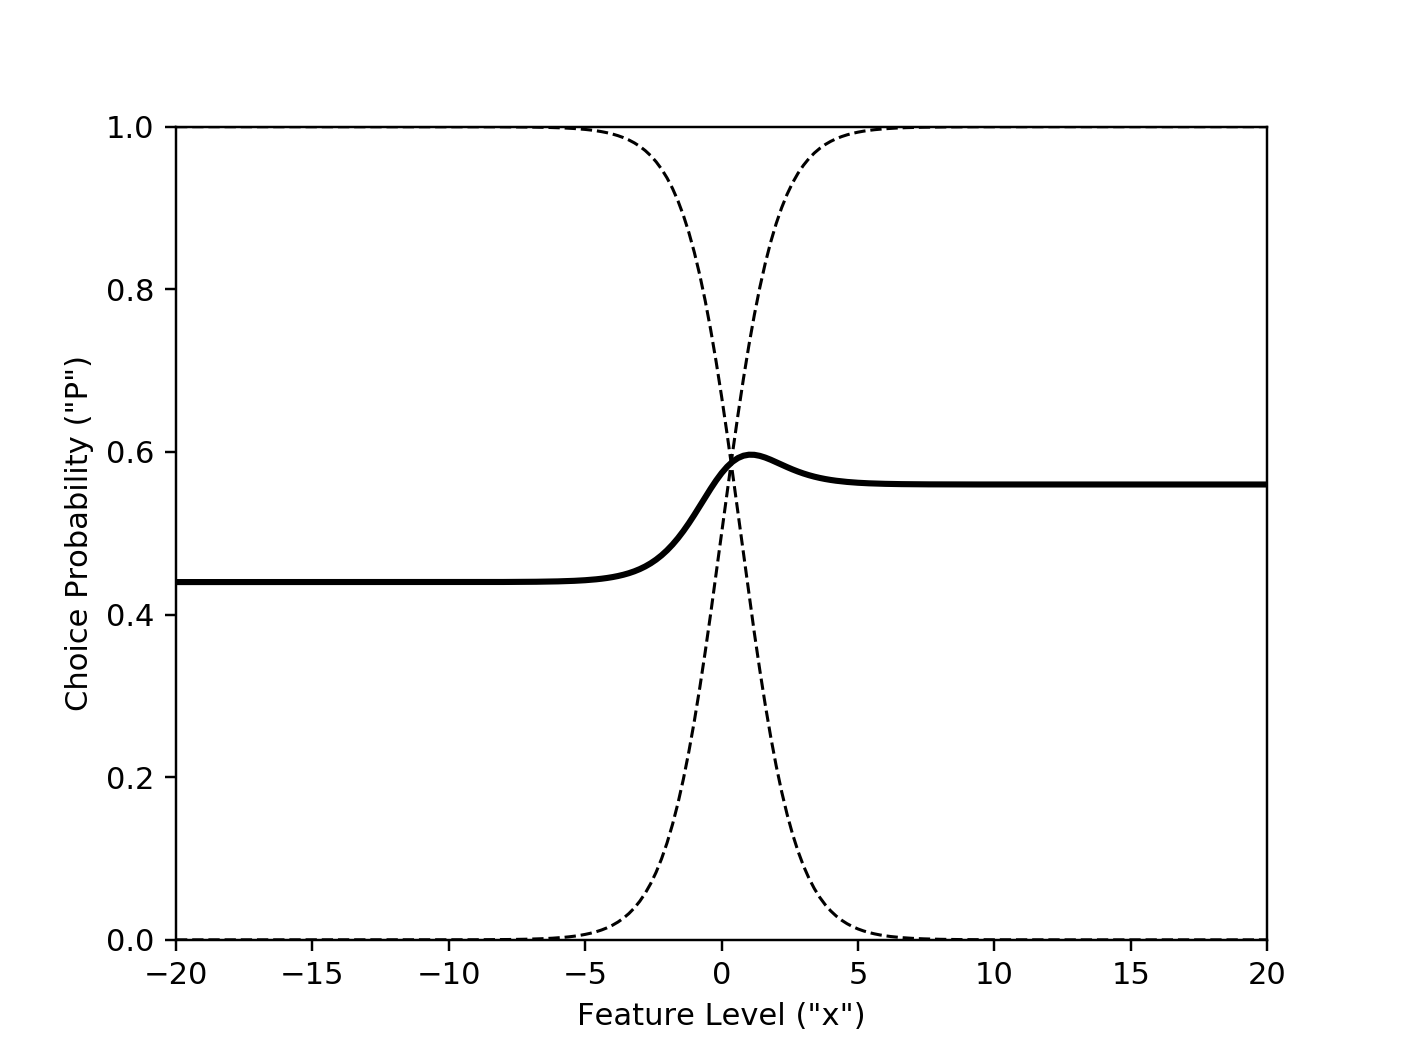

In [477]:


C = 2
bT = np.array( [ -1.00 ,  1.00 ] )
cT = np.array( [  0.70 ,  0.00 ] )

def lclprob( bT , cT , w , xmin=-20.0 , xmax=20.0 , xnum=200 ) : 
    xdel = ( xmax - xmin ) / xnum
    x = np.arange( xmin , xmax + 0.5*xdel , xdel )
    u = np.outer( x , bT ) + np.outer( np.ones(xnum+1) , cT ) 
    eU = np.exp( u )
    PL = eU / ( 1.0 + eU )
    return x , PL , PL @ w

def makeplots( x , PL , P ) : 
    
    plt.figure()
    plt.plot( x , PL[:,0] , '--k' , linewidth=1 )
    plt.plot( x , PL[:,1] , '--k' , linewidth=1 )
    plt.plot( x , P , '-k' , linewidth=2 )
    s="""
    soln = fitLogit( x , P )
    if( ( soln is not None ) and ( soln.status == 1 ) ) : 
        eLM = np.exp( soln.x[0] * x + soln.x[1] )
        PLM = eLM / ( 1.0 + eLM )
        plt.plot( x , PLM , '-b' , linewidth=2 )
        print( soln.x )
    
    C = 2
    soln = fitLCLogit( x , P )
    if( ( soln is not None ) and ( soln.status == 1 ) ) : 
        N  = x.size
        U  = np.outer( x , soln.x[C:2*C] ) + np.outer( np.ones(N) , soln.x[2*C:3*C] )
        EU = np.exp( U )
        PL = EU / ( 1.0 + EU ) # in R(N,C)
        PLC = PL @ soln.x[0:C]
        plt.plot( x , PLC  , ':y' , linewidth=2 )
        print( soln.x )
    else : 
        if soln is not None : 
            print( soln.status )
        
    soln = fitRCLogit( x , P )
    if( ( soln is not None ) and ( soln.status == 1 ) ) : 
        N  = x.size
        S  = int(1e5)
        Lg = np.zeros((2,2)) ; Lg[0,0] = soln.x[2] ; Lg[1,0] = soln.x[3] ; Lg[1,1] = soln.x[4]
        T  = np.outer( soln.x[0:2] , np.ones(S) ) + Lg @ np.random.randn(2,S)
        X  = np.ones((N,2)) ; X[:,0] = x
        EU = np.exp( X @ T )
        PL = EU / ( 1.0 + EU ) # in R(N,S)
        PRC = PL.mean( axis=1 )
        plt.plot( x , PRC , '-r' , linewidth=2 )
        print( soln.x )
    """
    
    plt.xlim(x.min(),x.max())
    plt.ylim(0,1)
    
    plt.xlabel( "Feature Level (\"x\")" )
    plt.ylabel( "Choice Probability (\"P\")" )

d = np.array( [  0.01 , -0.01 ] )

w = np.array( [ 0.44 , 0.56 ] )
x , PL , P = lclprob( bT , cT , w ) ; makeplots( x , PL , P )

#w = w + d ; print(w) ; x , PL , P = lclprob( bT , cT , w ) ; makeplots( x , PL , P )
#w = w + d ; print(w) ; x , PL , P = lclprob( bT , cT , w ) ; makeplots( x , PL , P )
#w = w + d ; print(w) ; x , PL , P = lclprob( bT , cT , w ) ; makeplots( x , PL , P )
#w = w + d ; print(w) ; x , PL , P = lclprob( bT , cT , w ) ; makeplots( x , PL , P )
#w = w + d ; print(w) ; x , PL , P = lclprob( bT , cT , w ) ; makeplots( x , PL , P )
#w = w + d ; print(w) ; x , PL , P = lclprob( bT , cT , w ) ; makeplots( x , PL , P )
#w = w + d ; print(w) ; x , PL , P = lclprob( bT , cT , w ) ; makeplots( x , PL , P )
#w = w + d ; print(w) ; x , PL , P = lclprob( bT , cT , w ) ; makeplots( x , PL , P )

# print out Gaussian solution

<IPython.core.display.Javascript object>


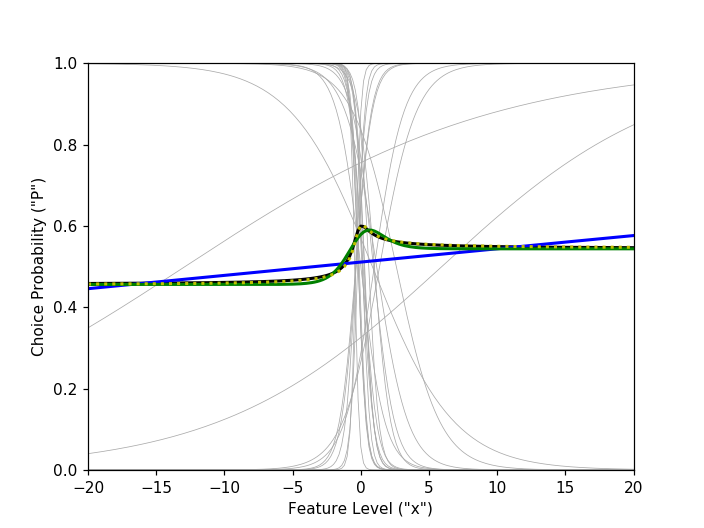

In [205]:

#mu = np.array( [ 0.3760554 , 0.48648951 ] )
#Lg = np.array( [[-3.41674137,0.0],[-0.58946019,-0.88912915]] )

mu = np.array( [ 0.4 , 0.5 ] )
Lg = np.array( [[-3.4,0.0],[-0.6,-0.9]] )

def grclprob( mu , Lg , xmin=-20.0 , xmax=20.0 , xnum=200 ) : 
    xdel = ( xmax - xmin ) / xnum
    x = np.arange( xmin , xmax + 0.5*xdel , xdel )
    S = int(1e5)
    V = np.random.randn(2,S)
    X = np.ones((x.size,2)) ; X[:,0] = x
    U = X @ ( np.outer( mu , np.ones(S) ) + Lg @ V )
    eU = np.exp( U )
    PL = eU / ( 1.0 + eU )
    return x , PL , PL.mean( axis=1 )

def makeplots( x , PL , P ) : 
    
    plt.figure()
    S = PL.shape[1]
    ss = np.random.choice( S , size=25 , replace=False )
    for i in range( 25 ) : 
        plt.plot( x , PL[:,ss[i]] , '-' , color="#aaaaaa" , linewidth=0.5 )
    plt.plot( x , P , '-k' , linewidth=2 )
    
    soln = fitLogit( x , P )
    if( ( soln is not None ) and ( soln.status == 1 ) ) : 
        eLM = np.exp( soln.x[0] * x + soln.x[1] )
        PLM = eLM / ( 1.0 + eLM )
        plt.plot( x , PLM , '-b' , linewidth=2 )
    
    C = 2
    soln = fitLCLogit( x , P )
    if( ( soln is not None ) and ( soln.status == 1 ) ) : 
        N  = x.size
        U  = np.outer( x , soln.x[C:2*C] ) + np.outer( np.ones(N) , soln.x[2*C:3*C] )
        EU = np.exp( U )
        PL = EU / ( 1.0 + EU ) # in R(N,C)
        PLC = PL @ soln.x[0:C]
        plt.plot( x , PLC  , '-g' , linewidth=2 )
    else : 
        if soln is not None : 
            print( soln.status )
        
    soln = fitRCLogit( x , P )
    if( ( soln is not None ) and ( soln.status == 1 ) ) : 
        N  = x.size
        S  = int(1e5)
        Lg = np.zeros((2,2)) ; Lg[0,0] = soln.x[2] ; Lg[1,0] = soln.x[3] ; Lg[1,1] = soln.x[4]
        T  = np.outer( soln.x[0:2] , np.ones(S) ) + Lg @ np.random.randn(2,S)
        X  = np.ones((N,2)) ; X[:,0] = x
        EU = np.exp( X @ T )
        PL = EU / ( 1.0 + EU ) # in R(N,S)
        PRC = PL.mean( axis=1 )
        plt.plot( x , PRC , ':y' , linewidth=2 )
    
    plt.xlim(x.min(),x.max())
    plt.ylim(0,1)
    
    plt.xlabel( "Feature Level (\"x\")" )
    plt.ylabel( "Choice Probability (\"P\")" )

x , PL , P = grclprob( mu , Lg ) ; 
makeplots( x , PL , P )

<IPython.core.display.Javascript object>


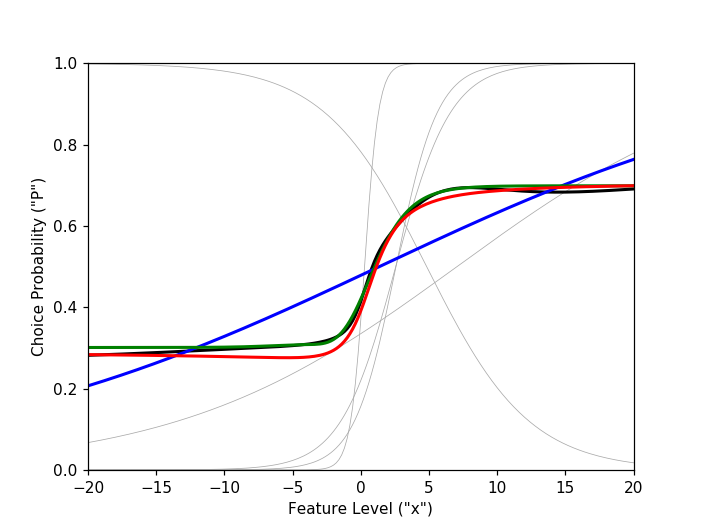

[ 0.06293692 -0.08551178]
[ 0.30113607  0.69886393 -0.78201462  0.62975745 -1.50517396  0.09178743]
0.1000000000000000 , 0.0428461578056563
0.0100000000000000 , 0.0047112475971170
0.0010000000000000 , 0.0004761849501659
0.0001000000000000 , 0.0000476705454281
0.0000100000000000 , 0.0000047675609297
0.0000010000000000 , 0.0000004765267350
0.0000001000000000 , 0.0000000449830454
0.0000000100000000 , 0.0000000228505781
0.0000000010000000 , 0.0000002647691785
0.0000000001000000 , 0.0000034953480308
[ 0.92309913 -1.06293293 -1.672445    0.40157293  3.37644801]


In [250]:


CT = 5
bT = np.random.randn(CT)
cT = np.random.randn(CT)

def lclprob( bT , cT , w , xmin=-20.0 , xmax=20.0 , xnum=200 ) : 
    xdel = ( xmax - xmin ) / xnum
    x = np.arange( xmin , xmax + 0.5*xdel , xdel )
    u = np.outer( x , bT ) + np.outer( np.ones(xnum+1) , cT ) 
    eU = np.exp( u )
    PL = eU / ( 1.0 + eU )
    return x , PL , PL @ w

def makeplots( x , PL , P ) : 
    
    plt.figure()
    for i in range(CT) : 
        plt.plot( x , PL[:,i] , '-' , color="#aaaaaa" , linewidth=0.5 )
    plt.plot( x , P , '-k' , linewidth=2 )
    
    soln = fitLogit( x , P )
    if( ( soln is not None ) and ( soln.status == 1 ) ) : 
        eLM = np.exp( soln.x[0] * x + soln.x[1] )
        PLM = eLM / ( 1.0 + eLM )
        plt.plot( x , PLM , '-b' , linewidth=2 )
        print( soln.x )
    else : 
        if soln is not None : 
            print( "Logit failed: " , soln.status )
    
    C = 2
    soln = fitLCLogit( x , P )
    if( ( soln is not None ) and ( soln.status == 1 ) ) : 
        N  = x.size
        U  = np.outer( x , soln.x[C:2*C] ) + np.outer( np.ones(N) , soln.x[2*C:3*C] )
        EU = np.exp( U )
        PL = EU / ( 1.0 + EU ) # in R(N,C)
        PLC = PL @ soln.x[0:C]
        plt.plot( x , PLC  , '-g' , linewidth=2 )
        print( soln.x )
    else : 
        if soln is not None : 
            print( "LC Logit failed: " , soln.status )
        
    soln = fitRCLogit( x , P )
    if( ( soln is not None ) and ( soln.status == 1 ) ) : 
        N  = x.size
        S  = int(1e5)
        Lg = np.zeros((2,2)) ; Lg[0,0] = soln.x[2] ; Lg[1,0] = soln.x[3] ; Lg[1,1] = soln.x[4]
        T  = np.outer( soln.x[0:2] , np.ones(S) ) + Lg @ np.random.randn(2,S)
        X  = np.ones((N,2)) ; X[:,0] = x
        EU = np.exp( X @ T )
        PL = EU / ( 1.0 + EU ) # in R(N,S)
        PRC = PL.mean( axis=1 )
        plt.plot( x , PRC , '-r' , linewidth=2 )
        print( soln.x )
    else : 
        if soln is not None : 
            print( "RC Logit failed: " , soln.status )
    
    plt.xlim(x.min(),x.max())
    plt.ylim(0,1)
    
    plt.xlabel( "Feature Level (\"x\")" )
    plt.ylabel( "Choice Probability (\"P\")" )


w = np.random.rand(CT) ; w = w / w.sum()
x , PL , P = lclprob( bT , cT , w ) ; makeplots( x , PL , P )


In [232]:
print( bT ) ; print( cT ) ; print( w )

[ 0.75471913  0.12520766  0.53714049 -1.18596893 -0.19534264]
[ 2.42933647 -0.17327294  0.95476831 -1.25533985  2.0159221 ]
[0.18350923 0.3673676  0.01030709 0.22246336 0.21635272]


<IPython.core.display.Javascript object>


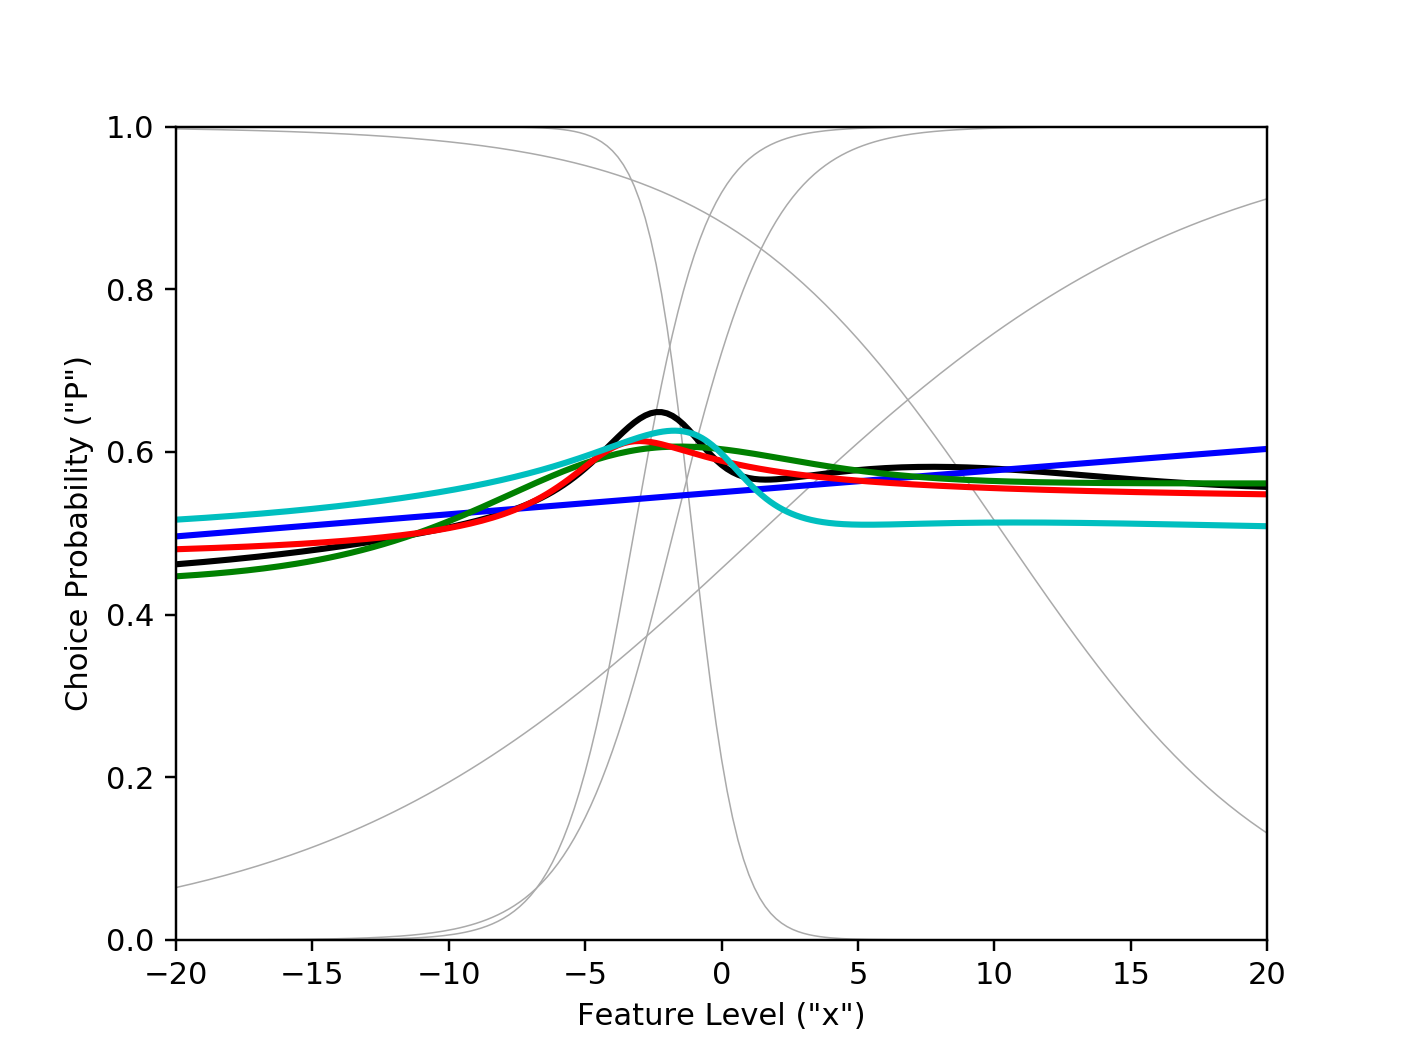

[0.01091134 0.20290084]
[ 0.56148206  0.43851794  0.25335761 -0.28519119  1.1196523  -0.36094404]
[ 0.09331463  1.01287403 -0.95547213 -3.67731925  1.66563132]
100000 100000
0.1000000000000000 , 0.1347508579243808
0.0100000000000000 , 0.0164524234955046
0.0010000000000000 , 0.0016782519577809
0.0001000000000000 , 0.0001681577698633
0.0000100000000000 , 0.0000168190594110
0.0000010000000000 , 0.0000016810352435
0.0000001000000000 , 0.0000001635824134
0.0000000100000000 , 0.0000001664160264
0.0000000010000000 , 0.0000016610711208
0.0000000001000000 , 0.0000175340199730


In [456]:


CT = 5
bT = np.array( [ 0.75471913 , 0.12520766 , 0.53714049, -1.18596893, -0.19534264] )
cT = np.array( [ 2.42933647 ,-0.17327294 , 0.95476831, -1.25533985,  2.0159221 ] )
w  = np.array( [0.18350923 ,0.3673676 , 0.01030709, 0.22246336, 0.21635272] )

def lclprob( bT , cT , w , xmin=-20.0 , xmax=20.0 , xnum=200 ) : 
    xdel = ( xmax - xmin ) / xnum
    x = np.arange( xmin , xmax + 0.5*xdel , xdel )
    u = np.outer( x , bT ) + np.outer( np.ones(xnum+1) , cT ) 
    eU = np.exp( u )
    PL = eU / ( 1.0 + eU )
    return x , PL , PL @ w

def lcldraws( bT , cT , w , Nx=1000 , I=100 , xmin=-20.0 , xmax=20.0 ) : 
    
    xdel = ( xmax - xmin ) / Nx
    x = ( xmax - xmin ) * np.random.rand( Nx ) + xmin
    
    ci = np.random.choice( CT , size=I , p=w )
    i  = np.random.randint( 0 , high=I , size=Nx )
    
    print( x.size , i.size )
    
    bi , ci = bT[ci[i]] , cT[ci[i]]
    U = bi * x + ci
    eU = np.exp( U )
    PL = eU / ( 1.0 + eU )
    y = 2.0 * ( np.random.rand(Nx) <= PL ) - 1.0
    
    return x , y , I , i

def makeplots( x , PL , P ) : 
    
    plt.figure()
    for i in range(CT) : 
        plt.plot( x , PL[:,i] , '-' , color="#aaaaaa" , linewidth=0.5 )
    plt.plot( x , P , '-k' , linewidth=2 )
    
    soln = fitLogit( x , P )
    if( ( soln is not None ) and ( soln.status == 1 ) ) : 
        eLM = np.exp( soln.x[0] * x + soln.x[1] )
        PLM = eLM / ( 1.0 + eLM )
        plt.plot( x , PLM , '-b' , linewidth=2 )
        print( soln.x )
    else : 
        if soln is not None : 
            print( "Logit failed: " , soln.status , soln.message )
    
    C = 2
    soln = fitLCLogit( x , P )
    if( ( soln is not None ) and ( soln.status == 1 ) ) : 
        N  = x.size
        U  = np.outer( x , soln.x[C:2*C] ) + np.outer( np.ones(N) , soln.x[2*C:3*C] )
        EU = np.exp( U )
        PL = EU / ( 1.0 + EU ) # in R(N,C)
        PLC = PL @ soln.x[0:C]
        plt.plot( x , PLC  , '-g' , linewidth=2 )
        print( soln.x )
    else : 
        if soln is not None : 
            print( "LC Logit failed: " , soln.status , soln.message )
        
    soln = fitRCLogit( x , P )
    if( ( soln is not None ) and ( soln.status == 1 ) ) : 
        N  = x.size
        S  = int(1e5)
        Lg = np.zeros((2,2)) ; Lg[0,0] = soln.x[2] ; Lg[1,0] = soln.x[3] ; Lg[1,1] = soln.x[4]
        T  = np.outer( soln.x[0:2] , np.ones(S) ) + Lg @ np.random.randn(2,S)
        X  = np.ones((N,2)) ; X[:,0] = x
        EU = np.exp( X @ T )
        PL = EU / ( 1.0 + EU ) # in R(N,S)
        PRC = PL.mean( axis=1 )
        plt.plot( x , PRC , '-r' , linewidth=2 )
        print( soln.x )
    else : 
        if soln is not None : 
            print( "RC Logit failed: " , soln.status , soln.message )
    
    plt.xlim(x.min(),x.max())
    plt.ylim(0,1)
    
    plt.xlabel( "Feature Level (\"x\")" )
    plt.ylabel( "Choice Probability (\"P\")" )


x , PL , P = lclprob( bT , cT , w ) ; makeplots( x , PL , P )

x , y , I , i = lcldraws( bT , cT , w , Nx=int(1e5) , I=100 )
soln = fitIdLogit( x , y , I , i , Lambda1=1.0 , Lambda2=0.0 )
if( ( soln is not None ) and ( soln.status == 1 ) ) : 
    b , d = soln.x[:2] , soln.x[2:2+2*I]
    B = np.outer( b , np.ones(I) )
    B[0,:] = B[0,:] + d[:I]
    B[1,:] = B[1,:] + d[I:]
    # B has coefficients for each "individual"
    X = np.ones( (x.size,2) ) ; X[:,0] = x
    U = X @ B # utilities for each individual, each "feature level"
    eU = np.exp( U )
    PL = eU / ( 1.0 + eU )
    PID = PL.mean( axis=1 )
    ind = np.argsort( x )
    plt.plot( x[ind] , PID[ind] , '-c' , linewidth=2 )
else : 
    if soln is not None : 
        print( "idLogit failed: " , soln.status , soln.message )


<IPython.core.display.Javascript object>


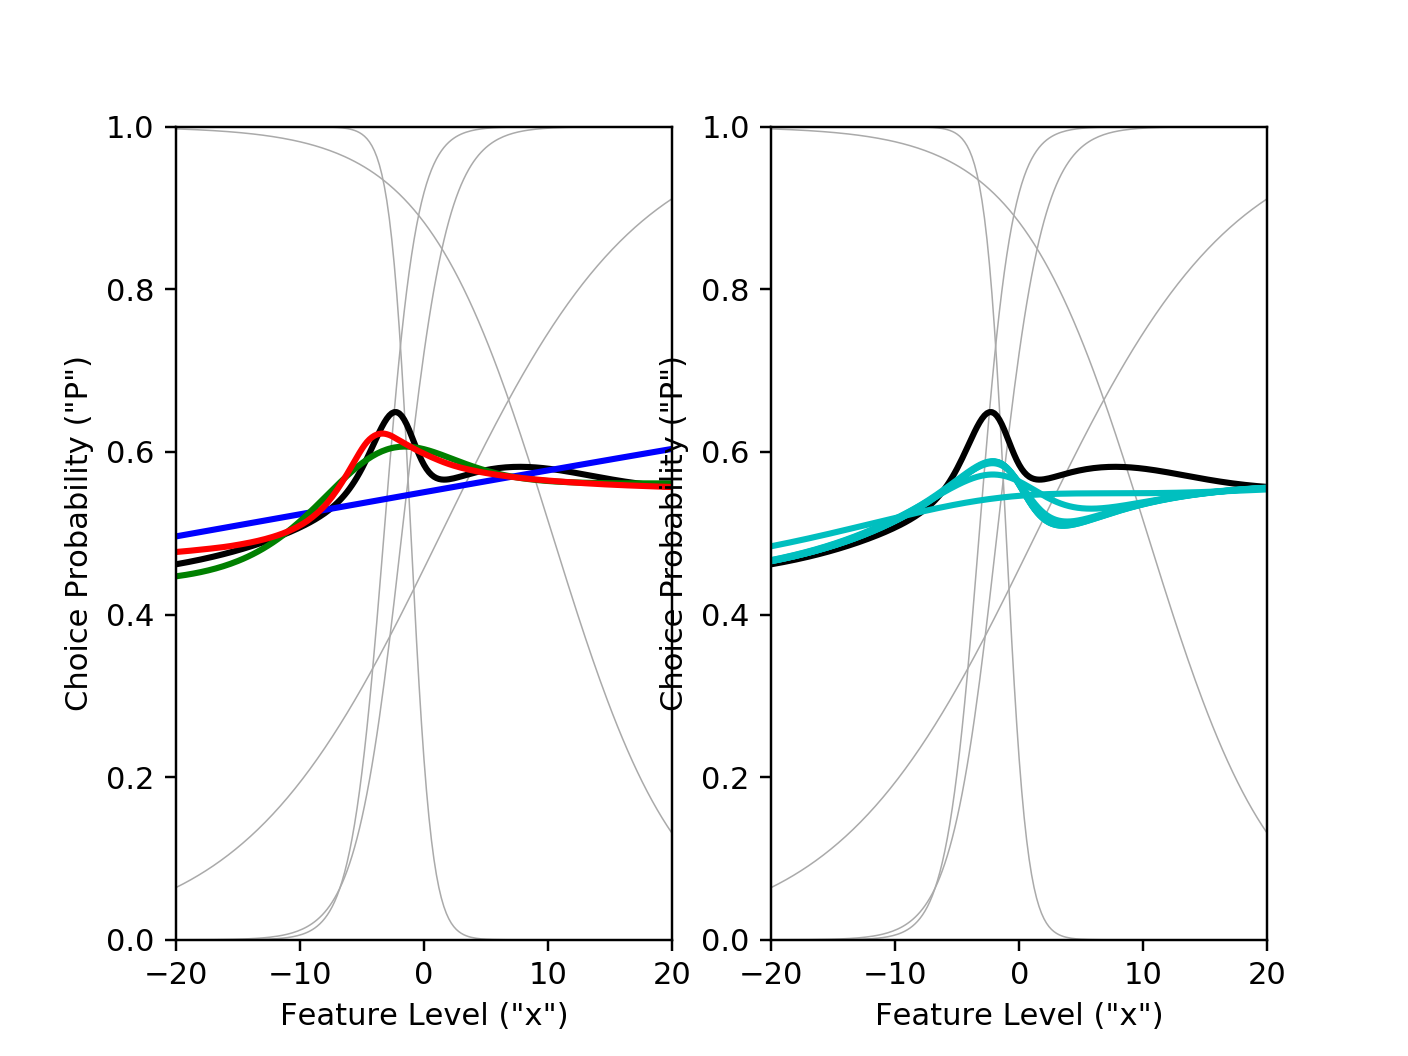

[0.01091134 0.20289951]
[ 0.43852044  0.56147956 -0.28517838  0.25336306 -0.36104195  1.11977019]
[  0.65860851   7.44464024  -5.62048264 -25.1073704   15.45336748]
100000 100000
fitting with:  1000.0
fitting idLogit:  0.01 0.01


/Users/morrowwr/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:107: RuntimeWarning: overflow encountered in log1p
/Users/morrowwr/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:107: RuntimeWarning: invalid value encountered in log1p


fitting with:  100.0
fitting idLogit:  0.001 0.001
fitting with:  10.0
fitting idLogit:  0.0001 0.0001
fitting with:  1.0
fitting idLogit:  1e-05 1e-05
fitting with:  0.1
fitting idLogit:  1e-06 1e-06
fitting with:  0.01
fitting idLogit:  1e-07 1e-07
fitting with:  0.001
fitting idLogit:  1e-08 1e-08


In [476]:

CT = 5
bT = np.array( [ 0.75471913 , 0.12520766 , 0.53714049, -1.18596893, -0.19534264] )
cT = np.array( [ 2.42933647 ,-0.17327294 , 0.95476831, -1.25533985,  2.0159221 ] )
w  = np.array( [0.18350923 ,0.3673676 , 0.01030709, 0.22246336, 0.21635272] )

def lclprob( bT , cT , w , xmin=-20.0 , xmax=20.0 , xnum=200 ) : 
    xdel = ( xmax - xmin ) / xnum
    x = np.arange( xmin , xmax + 0.5*xdel , xdel )
    u = np.outer( x , bT ) + np.outer( np.ones(xnum+1) , cT ) 
    eU = np.exp( u )
    PL = eU / ( 1.0 + eU )
    return x , PL , PL @ w

def lcldraws( bT , cT , w , Nx=1000 , I=100 , xmin=-20.0 , xmax=20.0 ) : 
    
    xdel = ( xmax - xmin ) / Nx
    x = ( xmax - xmin ) * np.random.rand( Nx ) + xmin
    
    ci = np.random.choice( CT , size=I , p=w )
    i  = np.random.randint( 0 , high=I , size=Nx )
    
    print( x.size , i.size )
    
    bi , ci = bT[ci[i]] , cT[ci[i]]
    U = bi * x + ci
    eU = np.exp( U )
    PL = eU / ( 1.0 + eU )
    y = 2.0 * ( np.random.rand(Nx) <= PL ) - 1.0
    
    return x , y , I , i

def idLogitProbs( x , I , coeffs ) : 
    B = np.outer( coeffs[:2] , np.ones(I) )
    B[0,:] = B[0,:] + coeffs[2:2+I]
    B[1,:] = B[1,:] + coeffs[2+I:2+2*I]
    # B has coefficients for each "individual"
    X = np.ones( (x.size,2) ) ; X[:,0] = x
    U = X @ B # utilities for each individual, each "feature level"
    eU = np.exp( U )
    PL = eU / ( 1.0 + eU )
    return PL.mean( axis=1 )

def makeplots( x , PL , P ) : 
    
    f , ax = plt.subplots(1,2)
    
    for p in range(2) : 
        for i in range(CT) : 
            ax[p].plot( x , PL[:,i] , '-' , color="#aaaaaa" , linewidth=0.5 )
        ax[p].plot( x , P , '-k' , linewidth=2 )
    
    soln = fitLogit( x , P )
    if( ( soln is not None ) and ( soln.status == 1 ) ) : 
        eLM = np.exp( soln.x[0] * x + soln.x[1] )
        PLM = eLM / ( 1.0 + eLM )
        ax[0].plot( x , PLM , '-b' , linewidth=2 )
        print( soln.x )
    else : 
        if soln is not None : 
            print( "Logit failed: " , soln.status , soln.message )
    
    C = 2
    soln = fitLCLogit( x , P )
    if( ( soln is not None ) and ( soln.status == 1 ) ) : 
        N  = x.size
        U  = np.outer( x , soln.x[C:2*C] ) + np.outer( np.ones(N) , soln.x[2*C:3*C] )
        EU = np.exp( U )
        PL = EU / ( 1.0 + EU ) # in R(N,C)
        PLC = PL @ soln.x[0:C]
        ax[0].plot( x , PLC  , '-g' , linewidth=2 )
        print( soln.x )
    else : 
        if soln is not None : 
            print( "LC Logit failed: " , soln.status , soln.message )
        
    soln = fitRCLogit( x , P )
    if( ( soln is not None ) and ( soln.status == 1 ) ) : 
        N  = x.size
        S  = int(1e5)
        Lg = np.zeros((2,2)) ; Lg[0,0] = soln.x[2] ; Lg[1,0] = soln.x[3] ; Lg[1,1] = soln.x[4]
        T  = np.outer( soln.x[0:2] , np.ones(S) ) + Lg @ np.random.randn(2,S)
        X  = np.ones((N,2)) ; X[:,0] = x
        EU = np.exp( X @ T )
        PL = EU / ( 1.0 + EU ) # in R(N,S)
        PRC = PL.mean( axis=1 )
        ax[0].plot( x , PRC , '-r' , linewidth=2 )
        print( soln.x )
    else : 
        if soln is not None : 
            print( "RC Logit failed: " , soln.status , soln.message )
            
    x , y , I , i = lcldraws( bT , cT , w , Nx=int(1e5) , I=100 )
    ind = np.argsort( x )
    
    Lambdas = x.size / ( 10.0 ** np.arange(2,9,1) )
    for l in range( Lambdas.size ) : 
        print( "fitting with: " , Lambdas[l] )
        soln = fitIdLogit( x , y , I , i , Lambda1=Lambdas[l] , Lambda2=1.0*Lambdas[l] )
        if( ( soln is not None ) and ( soln.status == 1 ) ) :
            PID = idLogitProbs( x , I , soln.x ) 
            ax[1].plot( x[ind] , PID[ind] , '-c' , linewidth=2 )
        else : 
            if soln is not None : 
                print( "idLogit failed: " , soln.status , soln.message )
    
    for p in range(2) : 
        ax[p].set_xlim(x.min(),x.max())
        ax[p].set_ylim(0,1)
        ax[p].set_xlabel( "Feature Level (\"x\")" )
        ax[p].set_ylabel( "Choice Probability (\"P\")" )


x , PL , P = lclprob( bT , cT , w ) ; makeplots( x , PL , P )


In [453]:

print( np.finfo( np.float64 ) )

number = 0.1 * 1.0e-323
npnumb = np.float64( number )

print( number )
print( npnumb )
print( np.log( npnumb ) )

print( np.log(2.2250738585072014e-308 ) )

print( np.exp( -708.4 ) >= 2.2250738585072014e-308 )

print( np.exp( 709.78 ) )

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------

0.0
0.0
-inf
-708.3964185322641
False
1.7928227943945155e+308


/Users/morrowwr/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
